# CAPTCHA BREAK 



1.   [EDA](https://colab.research.google.com/drive/18wxBUbptX2OS58gD1o_OI6Fbs_vYYXiX?usp=sharing)
2.   **MODEL**
3.   [EVAL](https://colab.research.google.com/drive/1BxBKW6NsCKV53hMai4xfQqzJtNquWfOx?usp=sharing)
4.   USAGE

---
---



# Busca de modelos
+ Será usada a acurácia na letra para encontrar melhor modelo

Notação dos modelos:
+ f**C**k: Camada convolucional com **f** *feature maps* usando filtros de tamanho **k x k** e *stride* de **1**;
+ 16**C**5**S**i: Camada convolucional com **16** *feature maps* usando filtros de tamanho **5x5** e *stride* de **i**;
+ **Pj**: *Max Pooling* de tamanho **j x j** e *stride* de **j**;
+ **F**s Camada densa totalmente conectada de **s** neurônios. 

Exemplo: **[16C5-P2] - F128** \\
Interpretramos como uma Rede Neural Convolucional de com uma camada de convolução com 16 filtros de 5x5 seguido por um *max pooling* de 2x2 e uma camadas de neurônios sendo a primeira de 128. 

Os modelos sempre terrão inputs de 40x40 pixels e saída de 26, correspondendo às letras do alfabeto.

[Fonte da Notação](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist#1.-How-many-convolution-subsambling-pairs?)

## Arquiteturas testadas


Primeiramente estamos testando modelos com variações nas combinações entre as camadas convolucionais, *max pooling*, camadas densas e seus respectivos parâmetros. Encontrada a melhor arquitetura de Rede Neural Convolucional serão testados *dropout*, *batch normalization* e *data augmentation* a fim de aumentar o poder de gereralização do modelo.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul 13 01:06:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    31W / 250W |   2597MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## Grid Search de modelos


In [33]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils.layer_utils import count_params
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import cv2
from imutils import paths
import os.path
from six.moves import cPickle as pickle # para salvar arquivos
import pandas as pd
import itertools
import time

In [3]:
def carrega_dados(tipo = 'fixed'):
    data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'

    if tipo == 'fixed':
        with open(data_dir+'LettersCaptchas_Fixed'+'_Data' +'.pickle', 'rb') as f:
            data = pickle.load(f)

        with open(data_dir+'LettersCaptchas_Fixed'+'_Labels'+'.pickle', 'rb') as f:
            labels = pickle.load(f)

    else:
        with open(data_dir+'LettersCaptchas'+'_Data' +'.pickle', 'rb') as f:
            data = pickle.load(f)

        with open(data_dir+'LettersCaptchas'+'_Labels'+'.pickle', 'rb') as f:
            labels = pickle.load(f)
    print("Dimensão Imagens %s | Dimensão dos Labels %s" % (data.shape, labels.shape))
    return [data, labels]

def prepare_data(data, labels):
    # Split the data
    (train_x, val_x, train_y, val_y) = train_test_split(data, labels, test_size=0.3, random_state=123)
    # one hot encoding
    lb = LabelBinarizer().fit(train_y)
    train_y = lb.transform(train_y)
    val_y = lb.transform(val_y)
    return train_x, val_x, train_y, val_y

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys()) 

def build_model1(n_hidden=1, conv=2, 
                 n_filter1=16, kernel_size1=5, mpool_siz1=2, 
                 n_filter2=64,  kernel_size2=5, mpool_siz2=2, 
                 n_filter3=64,  kernel_size3=5, mpool_siz3=2, 
                 n_neurons1=128, n_neurons2=128, learning_rate=3e-3):
    
    model = Sequential()
    model.add(Conv2D(n_filter1, (kernel_size1, kernel_size1), padding="same", input_shape=(40, 40, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(mpool_siz1, mpool_siz1), strides=(2, 2)))
    
    if conv > 0:
        model.add(Conv2D(n_filter2, (kernel_size2, kernel_size2), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(mpool_siz2, mpool_siz2), strides=(2, 2)))
        
    if conv > 1:
        model.add(Conv2D(n_filter3, (kernel_size3, kernel_size3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(mpool_siz3, mpool_siz3), strides=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(n_neurons1, activation="relu"))
    
    for layer in range(n_hidden-1):
        model.add(Dense(n_neurons2, activation="relu"))

    model.add(Dense(26, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


def build_model2(n_hidden=1, conv=2, 
                 n_filter1=16, kernel_size1=5, mpool_siz1=2, 
                 n_filter2=64,  kernel_size2=5, mpool_siz2=2, 
                 n_filter3=64,  kernel_size3=5, mpool_siz3=2, 
                 n_neurons1=128, n_neurons2=128, 
                 drop1=3, drop2=3, learning_rate=3e-3):
            
    model = Sequential()
    model.add(Conv2D(n_filter1, (kernel_size1, kernel_size1), padding="same", input_shape=(40, 40, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(mpool_siz1, mpool_siz1), strides=(2, 2)))
    model.add(BatchNormalization())

    if conv > 0:
        model.add(Conv2D(n_filter2, (kernel_size2, kernel_size2), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(mpool_siz2, mpool_siz2), strides=(2, 2)))
        model.add(BatchNormalization())

    if conv > 1:
        model.add(Conv2D(n_filter3, (kernel_size3, kernel_size3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(mpool_siz3, mpool_siz3), strides=(2, 2)))
        model.add(BatchNormalization())
    
    model.add(Flatten())
    
    model.add(Dense(n_neurons1, activation="relu"))
    model.add(Dropout(drop1/10))
    
    for layer in range(n_hidden-1):
        model.add(Dense(n_neurons2, activation="relu"))
        model.add(Dropout(drop2/10))

    model.add(Dense(26, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


def build_model3(n_hidden=1, conv=2, 
                 n_filter1=16, kernel_size1=5, mpool_siz1=2, 
                 n_filter2=64,  kernel_size2=5, mpool_siz2=2, s2=1,
                 n_filter3=64,  kernel_size3=5, mpool_siz3=2, s3=1,
                 n_filter4=64,  kernel_size4=5, mpool_siz4=2, s4=1,
                 n_filter5=64,  kernel_size5=5, mpool_siz5=2,  s5=1,
                 n_filter6=64,  kernel_size6=5, mpool_siz6=2,  s6=1,
                 n_neurons1=128, n_neurons2=128, 
                 drop1=3, drop2=3, learning_rate=3e-3):
            
    model = Sequential()
    model.add(Conv2D(n_filter1, (kernel_size1, kernel_size1), padding="same", input_shape=(40, 40, 1), activation="relu"))
    model.add(BatchNormalization())

    if conv > 0:
        model.add(Conv2D(n_filter2, (kernel_size2, kernel_size2), strides= s2, padding="same", activation="relu"))
        model.add(BatchNormalization())

    if conv > 1:
        model.add(Conv2D(n_filter3, (kernel_size3, kernel_size3),strides= s3,padding="same", activation="relu"))
        model.add(BatchNormalization())

    if conv > 2:
        model.add(Conv2D(n_filter4, (kernel_size4, kernel_size4),strides= s4, padding="same", activation="relu"))
        model.add(BatchNormalization())

    if conv > 3:
        model.add(Conv2D(n_filter5, (kernel_size5, kernel_size5), strides= s5,padding="same", activation="relu"))
        model.add(BatchNormalization())

    if conv > 4:
        model.add(Conv2D(n_filter6, (kernel_size6, kernel_size6),strides= s6, padding="same", activation="relu"))
        model.add(BatchNormalization())

    
    model.add(Flatten())
    
    model.add(Dense(n_neurons1, activation="relu"))
    model.add(Dropout(drop1/10))
    
    for layer in range(n_hidden-1):
        model.add(Dense(n_neurons2, activation="relu"))
        model.add(Dropout(drop2/10))

    model.add(Dense(26, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model



---
### Primeira Rodada

Testando número de pares de Conv2d e MaxPooling juntamente com número de parâmetros

In [ ]:
data, labels = carrega_dados('fixed')

train_x, val_x, train_y, val_y = prepare_data(data, labels)


parametros = {"n_hidden": [1],
              "conv":[0,1,2],
              "n_filter1":[8,16,32,64],
              "kernel_size1":[2], 
              "mpool_siz1":[2],
              "n_filter2":[8,16,32,64], 
              "kernel_size2":[2], 
              "mpool_siz2":[2],
              "n_filter3":[8,16,32,64], 
              "kernel_size3":[2], 
              "mpool_siz3":[2],
              "n_neurons1":[256],
              "n_neurons2":[0]
              }

grid_search =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
                                   'Param_Trein', 'Param_N_Trein'])

Dimensão Imagens (9635, 40, 40, 1) | Dimensão dos Labels (9635, 1)


In [ ]:
%%time
model = []
df = expand_grid(parametros)

df.loc[ df['n_hidden']==1, 'n_neurons2'] = 0
df.loc[ df['conv']==0, ('n_filter2', 'kernel_size2', 'mpool_siz2','n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df.loc[ df['conv']==1, ('n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df = df.drop_duplicates().reset_index(drop=True)

# 'n_filter2', 'kernel_size2', 'mpool_siz2','n_filter3','kernel_size3', 'mpool_siz3' 

nets = df.shape[0]
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(df.shape[0]):
    # Atribuindo parametros
    n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, n_filter2, \
     kernel_size2, mpool_siz2, n_filter3, kernel_size3, mpool_siz3, \
     n_neurons1, n_neurons2 = df.loc[j]

    # Compila Modelo
    model[j] = build_model1(n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, 
                         n_filter2, kernel_size2, mpool_siz2, n_filter3, 
                         kernel_size3, mpool_siz3, n_neurons1, n_neurons2, 
                         learning_rate=3e-3)
    
    estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

    start_time = time.time()
    history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                        batch_size=128, epochs=20, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,history.params['epochs'],max(history.history['accuracy']),
        max(history.history['val_accuracy']), total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          history.params['epochs'], np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 84 modelos
CNN 1: Epochs=20, Train acc=1.0000, Val acc=0.6582, Time=6 seconds
CNN 2: Epochs=20, Train acc=1.0000, Val acc=0.6562, Time=7 seconds
CNN 3: Epochs=20, Train acc=1.0000, Val acc=0.6551, Time=8 seconds
CNN 4: Epochs=20, Train acc=1.0000, Val acc=0.6423, Time=11 seconds
CNN 5: Epochs=20, Train acc=0.9997, Val acc=0.6818, Time=7 seconds
CNN 6: Epochs=20, Train acc=1.0000, Val acc=0.7617, Time=7 seconds
CNN 7: Epochs=20, Train acc=1.0000, Val acc=0.7641, Time=7 seconds
CNN 8: Epochs=20, Train acc=1.0000, Val acc=0.7814, Time=8 seconds
CNN 9: Epochs=20, Train acc=0.9997, Val acc=0.7029, Time=7 seconds
CNN 10: Epochs=20, Train acc=1.0000, Val acc=0.7606, Time=7 seconds
CNN 11: Epochs=20, Train acc=1.0000, Val acc=0.7731, Time=8 seconds
CNN 12: Epochs=20, Train acc=0.9999, Val acc=0.7956, Time=9 seconds
CNN 13: Epochs=20, Train acc=0.9999, Val acc=0.7523, Time=8 seconds
CNN 14: Epochs=20, Train acc=1.0000, Val acc=0.7641, Time=8 seconds
CNN 15: Epochs=20, Train acc=1

In [ ]:
# %load_ext google.colab.data_table 
#%unload_ext google.colab.data_table
grid_search

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein
0,1.0000,0.6565,20.0,6.5,826178.0,0.0
1,1.0000,0.6555,20.0,7.1,1645418.0,0.0
2,0.9462,0.5752,20.0,8.4,3283898.0,0.0
3,1.0000,0.6375,20.0,11.1,6560858.0,0.0
4,0.9997,0.6797,20.0,7.0,212042.0,0.0
...,...,...,...,...,...,...
79,0.9967,0.8796,20.0,10.4,433338.0,0.0
80,0.9822,0.8208,20.0,11.4,76962.0,0.0
81,0.9982,0.8471,20.0,11.1,130218.0,0.0
82,0.9953,0.8464,20.0,11.1,236730.0,0.0


In [ ]:
result1 = pd.concat([grid_search, df], axis=1)
result1

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2
0,1.0000,0.6565,20.0,6.5,826178.0,0.0,1,0,8,2,2,0,0,0,0,0,0,256,0
1,1.0000,0.6555,20.0,7.1,1645418.0,0.0,1,0,16,2,2,0,0,0,0,0,0,256,0
2,0.9462,0.5752,20.0,8.4,3283898.0,0.0,1,0,32,2,2,0,0,0,0,0,0,256,0
3,1.0000,0.6375,20.0,11.1,6560858.0,0.0,1,0,64,2,2,0,0,0,0,0,0,256,0
4,0.9997,0.6797,20.0,7.0,212042.0,0.0,1,1,8,2,2,8,2,2,0,0,0,256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.9967,0.8796,20.0,10.4,433338.0,0.0,1,2,64,2,2,32,2,2,64,2,2,256,0
80,0.9822,0.8208,20.0,11.4,76962.0,0.0,1,2,64,2,2,64,2,2,8,2,2,256,0
81,0.9982,0.8471,20.0,11.1,130218.0,0.0,1,2,64,2,2,64,2,2,16,2,2,256,0
82,0.9953,0.8464,20.0,11.1,236730.0,0.0,1,2,64,2,2,64,2,2,32,2,2,256,0


In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_1'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Grid_Table_1'+'_Shapes' +'.pickle', 'wb') as f:
    pickle.dump(result1, f, pickle.HIGHEST_PROTOCOL)

---
### Segunda Rodada

Na primeira rodada o modelo vencedor teve acurácia de validação de 87.7%:
+ [16C2 - P2] - [32C2 - P2] - [64C2 - P2]

Agora será testado a quantidade de camadas densas e respectivos neurônios.

In [ ]:
# data, labels = carrega_dados('fixed')
# train_x, val_x, train_y, val_y = prepare_data(data, labels)

parametros = {"n_hidden": [1,2],
              "conv":[2],               # Fixado
              "n_filter1":[16],         # Fixado
              "kernel_size1":[2],       
              "mpool_siz1":[2],
              "n_filter2":[32],         # Fixado
              "kernel_size2":[2], 
              "mpool_siz2":[2],
              "n_filter3":[64],         # Fixado
              "kernel_size3":[2], 
              "mpool_siz3":[2],
              "n_neurons1":[64,128,256,512,1024],
              "n_neurons2":[64,128,256,512,1024]
              }

grid_search =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
                                   'Param_Trein', 'Param_N_Trein'])


In [ ]:
%%time
model = []
df = expand_grid(parametros)

df.loc[ df['n_hidden']==1, 'n_neurons2'] = 0
df.loc[ df['conv']==0, ('n_filter2', 'kernel_size2', 'mpool_siz2','n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df.loc[ df['conv']==1, ('n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df = df.drop_duplicates().reset_index(drop=True)

nets = df.shape[0]
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(df.shape[0]):
    # Atribuindo parametros
    n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, n_filter2, \
     kernel_size2, mpool_siz2, n_filter3, kernel_size3, mpool_siz3, \
     n_neurons1, n_neurons2 = df.loc[j]

    # Compila Modelo
    model[j] = build_model1(n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, 
                         n_filter2, kernel_size2, mpool_siz2, n_filter3, 
                         kernel_size3, mpool_siz3, n_neurons1, n_neurons2, 
                         learning_rate=3e-3)
    
    estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

    start_time = time.time()
    history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                        batch_size=128, epochs=20, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,history.params['epochs'],max(history.history['accuracy']),
        max(history.history['val_accuracy']), total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          history.params['epochs'], np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 30 modelos
CNN 1: Epochs=20, Train acc=0.9917, Val acc=0.8468, Time=8 seconds
CNN 2: Epochs=20, Train acc=0.9972, Val acc=0.8423, Time=8 seconds
CNN 3: Epochs=20, Train acc=0.9969, Val acc=0.8457, Time=8 seconds
CNN 4: Epochs=20, Train acc=0.9954, Val acc=0.8658, Time=8 seconds
CNN 5: Epochs=20, Train acc=1.0000, Val acc=0.8841, Time=8 seconds
CNN 6: Epochs=20, Train acc=0.9838, Val acc=0.8340, Time=8 seconds
CNN 7: Epochs=20, Train acc=0.9896, Val acc=0.8523, Time=8 seconds
CNN 8: Epochs=20, Train acc=0.9843, Val acc=0.8499, Time=8 seconds
CNN 9: Epochs=20, Train acc=0.9905, Val acc=0.8679, Time=8 seconds
CNN 10: Epochs=20, Train acc=0.9929, Val acc=0.8648, Time=8 seconds
CNN 11: Epochs=20, Train acc=0.9969, Val acc=0.8547, Time=10 seconds
CNN 12: Epochs=20, Train acc=0.9948, Val acc=0.8720, Time=8 seconds
CNN 13: Epochs=20, Train acc=0.9935, Val acc=0.8758, Time=8 seconds
CNN 14: Epochs=20, Train acc=0.9985, Val acc=0.8890, Time=8 seconds
CNN 15: Epochs=20, Train acc=0

In [ ]:
result2 = pd.concat([grid_search, df], axis=1)
result2

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2
0,0.9832,0.8322,20.0,8.0,114570.0,0.0,1,2,16,2,2,32,2,2,64,2,2,64,0
1,0.9963,0.8385,20.0,8.0,218698.0,0.0,1,2,16,2,2,32,2,2,64,2,2,128,0
2,0.9880,0.8457,20.0,7.9,426954.0,0.0,1,2,16,2,2,32,2,2,64,2,2,256,0
3,0.9938,0.8596,20.0,8.1,843466.0,0.0,1,2,16,2,2,32,2,2,64,2,2,512,0
4,0.9997,0.8810,20.0,8.4,1676490.0,0.0,1,2,16,2,2,32,2,2,64,2,2,1024,0
5,0.9812,0.8277,20.0,8.2,118730.0,0.0,2,2,16,2,2,32,2,2,64,2,2,64,64
6,0.9896,0.8523,20.0,8.4,124554.0,0.0,2,2,16,2,2,32,2,2,64,2,2,64,128
7,0.9715,0.8447,20.0,8.3,136202.0,0.0,2,2,16,2,2,32,2,2,64,2,2,64,256
8,0.9905,0.8679,20.0,8.3,159498.0,0.0,2,2,16,2,2,32,2,2,64,2,2,64,512
9,0.9929,0.8648,20.0,8.3,206090.0,0.0,2,2,16,2,2,32,2,2,64,2,2,64,1024


In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_2'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Grid_Table_2' +'.pickle', 'wb') as f:
    pickle.dump(result2, f, pickle.HIGHEST_PROTOCOL)

---
### Terceira Rodada


Na primeira rodada o modelo vencedor teve acurácia de validação de 90.4%, um acréscimo de 2,7 na acurácia:

+ [16C2 - P2] - [32C2 - P2] - [64C2 - P2] - 1024 - 1024

Agora serão testados o tamanho do filtro na camada convolucional, o tamnaho do passo (*stride*), o tamanho do *MaxPooling*

In [ ]:
data, labels = carrega_dados('fixed')
train_x, val_x, train_y, val_y = prepare_data(data, labels)

parametros = {"n_hidden": [2],          # Fixado
              "conv":[2],               # Fixado
              "n_filter1":[16],         # Fixado
              "kernel_size1":[3,5],       
              "mpool_siz1":[2,5],
              "n_filter2":[32],         # Fixado
              "kernel_size2":[3,5], 
              "mpool_siz2":[2,5],
              "n_filter3":[64],         # Fixado
              "kernel_size3":[3,5], 
              "mpool_siz3":[2,5],
              "n_neurons1":[1024],      # Fixado
              "n_neurons2":[1024]       # Fixado
              }

grid_search =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
                                   'Param_Trein', 'Param_N_Trein'])


Dimensão Imagens (9635, 40, 40, 1) | Dimensão dos Labels (9635, 1)


In [ ]:
%%time
model = []
df = expand_grid(parametros)

df.loc[ df['n_hidden']==1, 'n_neurons2'] = 0
df.loc[ df['conv']==0, ('n_filter2', 'kernel_size2', 'mpool_siz2','n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df.loc[ df['conv']==1, ('n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df = df.drop_duplicates().reset_index(drop=True)

nets = df.shape[0]
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(df.shape[0]):
    # Atribuindo parametros
    n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, n_filter2, \
     kernel_size2, mpool_siz2, n_filter3, kernel_size3, mpool_siz3, \
     n_neurons1, n_neurons2 = df.loc[j]

    # Compila Modelo
    model[j] = build_model1(n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, 
                         n_filter2, kernel_size2, mpool_siz2, n_filter3, 
                         kernel_size3, mpool_siz3, n_neurons1, n_neurons2, 
                         learning_rate=3e-3)
    
    estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

    start_time = time.time()
    history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                        batch_size=128, epochs=20, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,history.params['epochs'],max(history.history['accuracy']),
        max(history.history['val_accuracy']), total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          history.params['epochs'], np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 64 modelos
CNN 1: Epochs=20, Train acc=0.9948, Val acc=0.9225, Time=16 seconds
CNN 2: Epochs=20, Train acc=0.9915, Val acc=0.9242, Time=9 seconds
CNN 3: Epochs=20, Train acc=0.9953, Val acc=0.9267, Time=10 seconds
CNN 4: Epochs=20, Train acc=0.9975, Val acc=0.9284, Time=10 seconds
CNN 5: Epochs=20, Train acc=0.9911, Val acc=0.9246, Time=9 seconds
CNN 6: Epochs=20, Train acc=0.9892, Val acc=0.9242, Time=9 seconds
CNN 7: Epochs=20, Train acc=0.9918, Val acc=0.9315, Time=10 seconds
CNN 8: Epochs=20, Train acc=0.9878, Val acc=0.9263, Time=10 seconds
CNN 9: Epochs=20, Train acc=0.9997, Val acc=0.9336, Time=10 seconds
CNN 10: Epochs=20, Train acc=0.9987, Val acc=0.9419, Time=10 seconds
CNN 11: Epochs=20, Train acc=0.9999, Val acc=0.9495, Time=11 seconds
CNN 12: Epochs=20, Train acc=0.9910, Val acc=0.9281, Time=10 seconds
CNN 13: Epochs=20, Train acc=0.9920, Val acc=0.9249, Time=10 seconds
CNN 14: Epochs=20, Train acc=0.9867, Val acc=0.9270, Time=10 seconds
CNN 15: Epochs=20, T

In [ ]:
%load_ext google.colab.data_table 
result3 = pd.concat([grid_search, df], axis=1)
result3

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2
0,0.9915,0.9225,20.0,15.9,2738970.0,0.0,2,2,16,3,2,32,3,2,64,3,2,1024,1024
1,0.9915,0.9242,20.0,9.4,1690394.0,0.0,2,2,16,3,2,32,3,2,64,3,5,1024,1024
2,0.9881,0.8786,20.0,10.2,2771738.0,0.0,2,2,16,3,2,32,3,2,64,5,2,1024,1024
3,0.9975,0.9211,20.0,9.5,1723162.0,0.0,2,2,16,3,2,32,3,2,64,5,5,1024,1024
4,0.9911,0.9097,20.0,9.5,2149146.0,0.0,2,2,16,3,2,32,3,5,64,3,2,1024,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.9948,0.9429,20.0,9.8,1731610.0,0.0,2,2,16,5,5,32,5,2,64,5,5,1024,1024
60,0.9748,0.9087,20.0,9.4,1698842.0,0.0,2,2,16,5,5,32,5,5,64,3,2,1024,1024
61,0.9695,0.9294,20.0,9.4,1371162.0,0.0,2,2,16,5,5,32,5,5,64,3,5,1024,1024
62,0.9807,0.9156,20.0,9.7,1731610.0,0.0,2,2,16,5,5,32,5,5,64,5,2,1024,1024


In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_3'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Grid_Table_3' +'.pickle', 'wb') as f:
    pickle.dump(result3, f, pickle.HIGHEST_PROTOCOL)

---
### Quarta Rodada

Adicionando dropout

Na Terceira rodada o modelo escolhido foi o segundo melhor por ter quase a mesma acurácia que o primeiro e ter quase metade dos parâmetros de treinamento. Sua acurácia de validação de 94.6%, um acréscimo de 2,4 na acurácia:

+ [16C5 - P5] - [32C5 - P2] - [64C3 - P5] - 1024 - 1024

Agora serão testados valores de dropout nas camadas densas e BatchNormalization após os MaxPooling.

In [ ]:
# data, labels = carrega_dados('fixed')
# train_x, val_x, train_y, val_y = prepare_data(data, labels)

seq = np.array(range(1,8) ).tolist()

parametros = {"n_hidden": [2],          # Fixado
              "conv":[2],               # Fixado
              "n_filter1":[16],         # Fixado
              "kernel_size1":[5],       # Fixado
              "mpool_siz1":[5],         # Fixado
              "n_filter2":[32],         # Fixado
              "kernel_size2":[5],       # Fixado
              "mpool_siz2":[2],         # Fixado
              "n_filter3":[64],         # Fixado
              "kernel_size3":[3],       # Fixado
              "mpool_siz3":[5],         # Fixado
              "n_neurons1":[1024],      # Fixado
              "n_neurons2":[1024],     # Fixado
              "drop1": seq,
              "drop2": seq
              }

grid_search =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
                                   'Param_Trein', 'Param_N_Trein'])


Dimensão Imagens (9635, 40, 40, 1) | Dimensão dos Labels (9635, 1)


In [ ]:
%%time
model = []
df = expand_grid(parametros)

df.loc[ df['n_hidden']==1, 'n_neurons2'] = 0
df.loc[ df['conv']==0, ('n_filter2', 'kernel_size2', 'mpool_siz2','n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df.loc[ df['conv']==1, ('n_filter3','kernel_size3', 'mpool_siz3' )] = 0
df = df.drop_duplicates().reset_index(drop=True)

nets = df.shape[0]
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(df.shape[0]):
    # Atribuindo parametros
    n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, n_filter2, \
     kernel_size2, mpool_siz2, n_filter3, kernel_size3, mpool_siz3, \
     n_neurons1, n_neurons2, drop1, drop2 = df.loc[j]

    # Compila Modelo
    model[j] = build_model2(n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, 
                         n_filter2, kernel_size2, mpool_siz2, n_filter3, 
                         kernel_size3, mpool_siz3, n_neurons1, n_neurons2,
                         drop1, drop2,
                         learning_rate=3e-3)
    
    estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

    start_time = time.time()
    history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                        batch_size=128, epochs=20, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,history.params['epochs'],max(history.history['accuracy']),
        max(history.history['val_accuracy']), total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          history.params['epochs'], np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 49 modelos
CNN 1: Epochs=20, Train acc=0.9911, Val acc=0.9370, Time=26 seconds
CNN 2: Epochs=20, Train acc=0.9899, Val acc=0.9370, Time=19 seconds
CNN 3: Epochs=20, Train acc=0.9957, Val acc=0.9512, Time=19 seconds
CNN 4: Epochs=20, Train acc=0.9918, Val acc=0.9464, Time=19 seconds
CNN 5: Epochs=20, Train acc=0.9862, Val acc=0.9360, Time=19 seconds
CNN 6: Epochs=20, Train acc=0.9867, Val acc=0.9512, Time=19 seconds
CNN 7: Epochs=20, Train acc=0.9803, Val acc=0.9391, Time=19 seconds
CNN 8: Epochs=20, Train acc=0.9893, Val acc=0.9422, Time=19 seconds
CNN 9: Epochs=20, Train acc=0.9893, Val acc=0.9405, Time=19 seconds
CNN 10: Epochs=20, Train acc=0.9895, Val acc=0.9419, Time=19 seconds
CNN 11: Epochs=20, Train acc=0.9841, Val acc=0.9498, Time=19 seconds
CNN 12: Epochs=20, Train acc=0.9907, Val acc=0.9547, Time=19 seconds
CNN 13: Epochs=20, Train acc=0.9864, Val acc=0.9478, Time=19 seconds
CNN 14: Epochs=20, Train acc=0.9812, Val acc=0.9464, Time=19 seconds
CNN 15: Epochs=20

In [ ]:
# %reload_ext google.colab.data_table
result4 = pd.concat([grid_search, df], axis=1)
result4.sort_values(by=['Val_Acc'], ascending=False).head()

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2,drop1,drop2
37,0.9761,0.9540,20.0,19.5,1699066.0,224.0,2,2,16,5,5,32,5,2,64,3,5,1024,1024,6,3
28,0.9806,0.9533,20.0,19.3,1699066.0,224.0,2,2,16,5,5,32,5,2,64,3,5,1024,1024,5,1
10,0.9841,0.9498,20.0,19.4,1699066.0,224.0,2,2,16,5,5,32,5,2,64,3,5,1024,1024,2,4
34,0.9690,0.9492,20.0,19.4,1699066.0,224.0,2,2,16,5,5,32,5,2,64,3,5,1024,1024,5,7
12,0.9849,0.9478,20.0,19.1,1699066.0,224.0,2,2,16,5,5,32,5,2,64,3,5,1024,1024,2,6


In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_4'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Grid_Table_4' +'.pickle', 'wb') as f:
    pickle.dump(result4, f, pickle.HIGHEST_PROTOCOL)

---
### Quinta Rodada - ULTIMA


Na Quarta rodada o modelo vencedor teve acurácia de validação de 95,4% um acréscimo de 0.8% na acurácia:

+ [16C5 - P5] - [32C5 - P2] - [64C3 - P5] - 1024 drop(0.6) - 1024 drop(0.3)

Testar uma estrutura de Convoluções seguidas

Agora serão testados valores de dropout nas camadas densas e BatchNormalization após os MaxPooling.

In [ ]:
# data, labels = carrega_dados('fixed')
# train_x, val_x, train_y, val_y = prepare_data(data, labels)


parametros = {"n_hidden": [2],         
              "conv":[5],        
              "n_filter1":[32],  
              "kernel_size1":[5],  
              "n_filter2":[32],  
              "kernel_size2":[3,5],   
              "n_filter3":[32],
              "kernel_size3":[3,5],
              "s3":[2],

              "n_filter4":[64],
              "kernel_size4":[3,5],
              "n_filter5":[64],
              "kernel_size5":[3,5],
              "n_filter6":[64],
              "kernel_size6":[2],
              "s6":[1,3],

              "n_neurons1":[1024],     
              "n_neurons2":[1024],     
              "drop1": [6],
              "drop2": [3]
              }

# grid_search1 =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
#                                    'Param_Trein', 'Param_N_Trein'])


model = []
df = expand_grid(parametros)
print(df.shape)
df.loc[ df['n_hidden']==1, 'n_neurons2'] = 0
df.loc[ df['conv']==0, ('n_filter2', 'kernel_size2',
                        'n_filter3','kernel_size3','s3',
                        'n_filter4','kernel_size4',
                        'n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==1, ('n_filter3','kernel_size3','s3',
                        'n_filter4','kernel_size4',
                        'n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==2, ('n_filter4','kernel_size4',
                        'n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==3, ('n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==4, ('n_filter6','kernel_size6','s6')] = 0


df.loc[ df['n_filter1']>df['n_filter2'], ('n_filter2','kernel_size2',
                                          'n_filter3','kernel_size3','s3',
                                          'n_filter4','kernel_size4',
                                          'n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['n_filter2']>df['n_filter3'], ('n_filter3','kernel_size3','s3',
                                          'n_filter4','kernel_size4',
                                          'n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6')] = 0

df.loc[ df['n_filter3']>df['n_filter4'], ('n_filter4','kernel_size4',
                                          'n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6','s6')] = 0

df.loc[ df['n_filter4']>df['n_filter5'], ('n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['n_filter5']>df['n_filter6'], ('n_filter6','kernel_size6','s6')] = 0
df = df.drop_duplicates().reset_index(drop=True)

nets = df.shape[0]
model = [0] *nets

print("Serão testados %s modelos" % nets)

(32, 20)
Serão testados 32 modelos


In [ ]:
%%time
model = []
df = expand_grid(parametros)

df.loc[ df['n_hidden']==1, 'n_neurons2'] = 0
df.loc[ df['conv']==0, ('n_filter2', 'kernel_size2',
                        'n_filter3','kernel_size3','s3',
                        'n_filter4','kernel_size4',
                        'n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==1, ('n_filter3','kernel_size3','s3',
                        'n_filter4','kernel_size4',
                        'n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==2, ('n_filter4','kernel_size4',
                        'n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==3, ('n_filter5','kernel_size5',
                        'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['conv']==4, ('n_filter6','kernel_size6','s6')] = 0


df.loc[ df['n_filter1']>df['n_filter2'], ('n_filter2','kernel_size2',
                                          'n_filter3','kernel_size3','s3',
                                          'n_filter4','kernel_size4',
                                          'n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['n_filter2']>df['n_filter3'], ('n_filter3','kernel_size3','s3',
                                          'n_filter4','kernel_size4',
                                          'n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6')] = 0

df.loc[ df['n_filter3']>df['n_filter4'], ('n_filter4','kernel_size4',
                                          'n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6','s6')] = 0

df.loc[ df['n_filter4']>df['n_filter5'], ('n_filter5','kernel_size5',
                                          'n_filter6','kernel_size6','s6')] = 0
df.loc[ df['n_filter5']>df['n_filter6'], ('n_filter6','kernel_size6','s6')] = 0
df = df.drop_duplicates().reset_index(drop=True)

nets = df.shape[0]
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(df.shape[0]):
    # Atribuindo parametros
    n_hidden,conv,n_filter1,kernel_size1,n_filter2,  \
    kernel_size2,n_filter3,kernel_size3,s3,n_filter4, \
    kernel_size4,n_filter5,kernel_size5,n_filter6,     \
    kernel_size6,s6,n_neurons1,n_neurons2,drop1,drop2 = df.loc[j]

    # Compila Modelo
    model[j] = build_model3(n_hidden=n_hidden, conv=conv, 
                            n_filter1=n_filter1, kernel_size1=kernel_size1,
                            n_filter2=n_filter2,  kernel_size2=kernel_size2, 
                            n_filter3=n_filter3,  kernel_size3=kernel_size3, s3=s3,
                            n_filter4=n_filter4,  kernel_size4=kernel_size4, 
                            n_filter5=n_filter5,  kernel_size5=kernel_size5, 
                            n_filter6=n_filter6,  kernel_size6=kernel_size6, s6=s6, 
                            n_neurons1=128, n_neurons2=128, 
                            drop1=drop1, drop2=drop2)

    
    estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

    start_time = time.time()
    history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                        batch_size=128, epochs=20, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,history.params['epochs'],max(history.history['accuracy']),
        max(history.history['val_accuracy']), total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          history.params['epochs'], np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 32 modelos
CNN 1: Epochs=20, Train acc=0.9355, Val acc=0.9398, Time=93 seconds
CNN 2: Epochs=20, Train acc=0.9816, Val acc=0.9526, Time=82 seconds
CNN 3: Epochs=20, Train acc=0.9328, Val acc=0.9440, Time=97 seconds
CNN 4: Epochs=20, Train acc=0.9813, Val acc=0.9602, Time=83 seconds
CNN 5: Epochs=20, Train acc=0.9356, Val acc=0.9530, Time=97 seconds
CNN 6: Epochs=20, Train acc=0.9782, Val acc=0.9495, Time=84 seconds
CNN 7: Epochs=20, Train acc=0.7254, Val acc=0.7876, Time=100 seconds
CNN 8: Epochs=20, Train acc=0.9840, Val acc=0.9536, Time=88 seconds
CNN 9: Epochs=20, Train acc=0.9410, Val acc=0.9505, Time=97 seconds
CNN 10: Epochs=20, Train acc=0.9751, Val acc=0.9485, Time=84 seconds
CNN 11: Epochs=20, Train acc=0.7862, Val acc=0.8495, Time=100 seconds
CNN 12: Epochs=20, Train acc=0.9794, Val acc=0.9516, Time=88 seconds
CNN 13: Epochs=20, Train acc=0.7801, Val acc=0.8281, Time=100 seconds
CNN 14: Epochs=20, Train acc=0.9864, Val acc=0.9609, Time=87 seconds
CNN 15: Epochs

In [ ]:
result5 = pd.concat([grid_search, df], axis=1)
result5.sort_values(by=['Val_Acc'], ascending=False).head()

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,n_filter2,kernel_size2,n_filter3,kernel_size3,s3,n_filter4,kernel_size4,n_filter5,kernel_size5,n_filter6,kernel_size6,s6,n_neurons1,n_neurons2,drop1,drop2
29,0.9843,0.9633,20.0,97.7,578714.0,576.0,2.0,5.0,32.0,5.0,32.0,5.0,32.0,5.0,2.0,64.0,5.0,64.0,3.0,64.0,2.0,3.0,1024.0,1024.0,3.0,2.0
31,0.9831,0.9633,20.0,100.6,644250.0,576.0,2.0,5.0,32.0,5.0,32.0,5.0,32.0,5.0,2.0,64.0,5.0,64.0,5.0,64.0,2.0,3.0,1024.0,1024.0,3.0,2.0
13,0.9864,0.9609,20.0,87.2,562330.0,576.0,2.0,5.0,32.0,5.0,32.0,3.0,32.0,5.0,2.0,64.0,5.0,64.0,3.0,64.0,2.0,3.0,1024.0,1024.0,3.0,2.0
3,0.9813,0.9602,20.0,83.4,578714.0,576.0,2.0,5.0,32.0,5.0,32.0,3.0,32.0,3.0,2.0,64.0,3.0,64.0,5.0,64.0,2.0,3.0,1024.0,1024.0,3.0,2.0
23,0.9872,0.9540,20.0,97.3,627866.0,576.0,2.0,5.0,32.0,5.0,32.0,5.0,32.0,3.0,2.0,64.0,5.0,64.0,5.0,64.0,2.0,3.0,1024.0,1024.0,3.0,2.0


In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_5'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Grid_Table_5' +'.pickle', 'wb') as f:
    pickle.dump(result5, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'

with open(data_dir+'Grid_Table_1' +'.pickle', 'rb') as f:
    result1 = pickle.load(f)

with open(data_dir+'Grid_Table_2' +'.pickle', 'rb') as f:
    result2 = pickle.load(f)

with open(data_dir+'Grid_Table_3' +'.pickle', 'rb') as f:
    result3 = pickle.load(f)

with open(data_dir+'Grid_Table_4' +'.pickle', 'rb') as f:
    result4 = pickle.load(f)

In [ ]:
result1.insert(0,'rodada', 1)
result2.insert(0,'rodada', 2)
result3.insert(0,'rodada', 3)
result4.insert(0,'rodada', 4)
result5.insert(0,'rodada', 5)

resultados = pd.concat([result1,result2,result3,result4, result5])
resultados

In [ ]:
# %load_ext google.colab.data_table
# %unload_ext google.colab.data_table
from google.colab import data_table
data_table.DataTable(resultados, include_index=True, num_rows_per_page=10, max_columns=35)

,rodada,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2,drop1,drop2,s3,n_filter4,kernel_size4,n_filter5,kernel_size5,n_filter6,kernel_size6,s6
0,1,1.0000,0.6565,20.0,6.5,826178.0,0.0,1.0,0.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0000,0.6555,20.0,7.1,1645418.0,0.0,1.0,0.0,16.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.9462,0.5752,20.0,8.4,3283898.0,0.0,1.0,0.0,32.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1.0000,0.6375,20.0,11.1,6560858.0,0.0,1.0,0.0,64.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.9997,0.6797,20.0,7.0,212042.0,0.0,1.0,1.0,8.0,2.0,2.0,8.0,2.0,2.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,5,0.9703,0.9471,20.0,19.5,1699066.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,5,0.9567,0.9267,20.0,19.4,1699066.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,5,0.9677,0.9329,20.0,19.3,1699066.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,5,0.9554,0.9443,20.0,19.9,1699066.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## Grid Search - Conclusão

Melhor modelo encontrado possui **96.3%** de acurácia com a seguinte configuração:

+ [32C5-32C55-32C5S2]-[64C5-64C3-64C2S3] - 1024 drop(0.6) - 1024 drop(0.3)

## Próximos Passos

+ Deixar os melhores modelos de cada rodada executarem até o fim
+ Organizar EDA - MODEL - EVAL 
+ Plotar acuracias por rodada, numero de parametros e etc


## Melhores Modelos com 20 Épocas



1.   **Val_Acc = 87,7%** [16C2 - P2] - [32C2 - P2] - [64C2 - P2] - F256-F256 
2.   **Val_Acc = 90,4%** [16C2 - P2] - [32C2 - P2] - [64C2 - P2] - F1024-F1024
3.   **Val_Acc = 94,6%** [16C5 - P5] - [32C5 - P2] - [64C3 - P5] - F1024-F1024
4.   **Val_Acc = 95,4%** [16C5 - P5] - [32C5 - P2] - [64C3 - P5] - F1024-drop(0.6)-F1024-drop(0.3)
5.   **Val_Acc = 96,3%** [32C5-32C55-32C5S2]-[64C5-64C3-64C2S3] - F1024-drop(0.6) -F1024-drop(0.3)




In [6]:
data, labels = carrega_dados('fixed')
train_x, val_x, train_y, val_y = prepare_data(data, labels)

parametros={"n_hidden": [2,2,2,2], 
            "conv":[2,2,2,2],             
            "n_filter1":[16,16,16,16],      
            "kernel_size1":[2,2,5,5],     
            "mpool_siz1":[2,2,5,5],       
            "n_filter2":[32,32,32,32],      
            "kernel_size2":[2,2,5,5],     
            "mpool_siz2":[2,2,2,2],       
            "n_filter3":[64,64,64,64],      
            "kernel_size3":[2,2,5,5],     
            "mpool_siz3":[2,2,5,5],
            "n_neurons1":[1024,1024,1024,1024], 
            "n_neurons2":[1024,1024,1024,1024] ,
            "drop1": [0,0,0,6],
            "drop2": [0,0,0,3]
}

parametros5 = {"n_hidden": [2],
              "conv":[5],        
              "n_filter1":[32],  
              "kernel_size1":[5],  
              "n_filter2":[32],  
              "kernel_size2":[5],   
              "n_filter3":[32],
              "kernel_size3":[5],
              "s3":[2],

              "n_filter4":[64],
              "kernel_size4":[5],
              "n_filter5":[64],
              "kernel_size5":[3],
              "n_filter6":[64],
              "kernel_size6":[2],
              "s6":[3],

              "n_neurons1":[1024],     
              "n_neurons2":[1024],     
              "drop1": [6],
              "drop2": [3]
              }

param_1_4 = pd.DataFrame(parametros)
param_5 = pd.DataFrame(parametros5)

grid_search =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
                                   'Param_Trein', 'Param_N_Trein'])

Dimensão Imagens (9635, 40, 40, 1) | Dimensão dos Labels (9635, 1)


In [19]:
%%time
model = []

nets = 5
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(nets):
    start_time = time.time()

    if j < 4:
        n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, n_filter2, \
        kernel_size2, mpool_siz2, n_filter3, kernel_size3, mpool_siz3, \
        n_neurons1, n_neurons2, drop1, drop2 = param_1_4.loc[j]

        # Compila Modelo
        model[j] = build_model2(n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, 
                            n_filter2, kernel_size2, mpool_siz2, n_filter3, 
                            kernel_size3, mpool_siz3, n_neurons1, n_neurons2,
                            drop1, drop2,
                            learning_rate=3e-3)
        
        estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')
        
        history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                        batch_size=128, epochs=500, verbose=0, callbacks=[estop])
    
    if j == 4:
        n_hidden,conv,n_filter1,kernel_size1,n_filter2,  \
        kernel_size2,n_filter3,kernel_size3,s3,n_filter4, \
        kernel_size4,n_filter5,kernel_size5,n_filter6,     \
        kernel_size6,s6,n_neurons1,n_neurons2,drop1,drop2 = param_5.loc[0]

        model[j] = build_model3(n_hidden=n_hidden, conv=conv, 
                                n_filter1=n_filter1, kernel_size1=kernel_size1,
                                n_filter2=n_filter2,  kernel_size2=kernel_size2, 
                                n_filter3=n_filter3,  kernel_size3=kernel_size3, s3=s3,
                                n_filter4=n_filter4,  kernel_size4=kernel_size4, 
                                n_filter5=n_filter5,  kernel_size5=kernel_size5, 
                                n_filter6=n_filter6,  kernel_size6=kernel_size6, s6=s6, 
                                n_neurons1=n_neurons1, n_neurons2=n_neurons2, 
                                drop1=drop1, drop2=drop2)
        
        estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

        history = model[j].fit(train_x, train_y, validation_data=(val_x, val_y), 
                            batch_size=128, epochs=500, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,len(history.history['loss']) ,history.history['accuracy'][-1],
        history.history['val_accuracy'][-1], total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          len(history.history['loss']), np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 5 modelos
CNN 1: Epochs=42, Train acc=1.0000, Val acc=0.8616, Time=55 seconds
CNN 2: Epochs=30, Train acc=1.0000, Val acc=0.8402, Time=40 seconds
CNN 3: Epochs=56, Train acc=1.0000, Val acc=0.9668, Time=75 seconds
CNN 4: Epochs=42, Train acc=0.9856, Val acc=0.9536, Time=58 seconds
CNN 5: Epochs=37, Train acc=0.9858, Val acc=0.9571, Time=245 seconds
CPU times: user 5min 40s, sys: 1min 28s, total: 7min 8s
Wall time: 7min 51s


In [20]:
%load_ext google.colab.data_table
grid_search

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein
0,1.0000,0.8616,42.0,55.1,2726314.0,224.0
1,1.0000,0.8402,30.0,40.1,2726314.0,224.0
2,1.0000,0.9668,56.0,74.5,1731834.0,224.0
3,0.9856,0.9536,42.0,57.5,1731834.0,224.0
4,0.9858,0.9571,37.0,244.7,4445850.0,576.0


In [26]:
# %load_ext google.colab.data_table
para = pd.concat([param_1_4, param_5]).reset_index()

result = pd.concat([grid_search, para], axis=1)
result
# result.sort_values(by=['Val_Acc'], ascending=False).head()

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,index,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2,drop1,drop2,s3,n_filter4,kernel_size4,n_filter5,kernel_size5,n_filter6,kernel_size6,s6
0,1.0000,0.8616,42.0,55.1,2726314.0,224.0,0,2,2,16,2,2.0,32,2,2.0,64,2,2.0,1024,1024,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0000,0.8402,30.0,40.1,2726314.0,224.0,1,2,2,16,2,2.0,32,2,2.0,64,2,2.0,1024,1024,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0000,0.9668,56.0,74.5,1731834.0,224.0,2,2,2,16,5,5.0,32,5,2.0,64,5,5.0,1024,1024,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.9856,0.9536,42.0,57.5,1731834.0,224.0,3,2,2,16,5,5.0,32,5,2.0,64,5,5.0,1024,1024,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.9858,0.9571,37.0,244.7,4445850.0,576.0,0,2,5,32,5,NaN,32,5,NaN,32,5,NaN,1024,1024,6,3,2.0,64.0,5.0,64.0,3.0,64.0,2.0,3.0


In [36]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_6'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Grid_Table_6' +'.pickle', 'wb') as f:
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

## Vou retreinar os três melhores modelos utilizando também Data Augmentation

In [35]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range = 0.15,  
    width_shift_range=0.1, 
    height_shift_range=0.1)

In [46]:
%%time
model = []
param_1_2 = param_1_4.iloc[2:].reset_index(drop=True)

grid_search =pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Epoch','Time',
                                   'Param_Trein', 'Param_N_Trein'])

nets = 3
model = [0] *nets

print("Serão testados %s modelos" % nets)


for j in range(nets):
    start_time = time.time()

    if j < 2:
        n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, n_filter2, \
        kernel_size2, mpool_siz2, n_filter3, kernel_size3, mpool_siz3, \
        n_neurons1, n_neurons2, drop1, drop2 = param_1_2.loc[j]

        # Compila Modelo
        model[j] = build_model2(n_hidden, conv, n_filter1, kernel_size1, mpool_siz1, 
                            n_filter2, kernel_size2, mpool_siz2, n_filter3, 
                            kernel_size3, mpool_siz3, n_neurons1, n_neurons2,
                            drop1, drop2,
                            learning_rate=3e-3)
        
        estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')
        
        history = model[j].fit_generator(datagen.flow(train_x,train_y), 
                                         validation_data=(val_x, val_y),
                                         epochs=500, verbose=0, callbacks=[estop])
    
    if j == 2:
        n_hidden,conv,n_filter1,kernel_size1,n_filter2,  \
        kernel_size2,n_filter3,kernel_size3,s3,n_filter4, \
        kernel_size4,n_filter5,kernel_size5,n_filter6,     \
        kernel_size6,s6,n_neurons1,n_neurons2,drop1,drop2 = param_5.loc[0]

        model[j] = build_model3(n_hidden=n_hidden, conv=conv, 
                                n_filter1=n_filter1, kernel_size1=kernel_size1,
                                n_filter2=n_filter2,  kernel_size2=kernel_size2, 
                                n_filter3=n_filter3,  kernel_size3=kernel_size3, s3=s3,
                                n_filter4=n_filter4,  kernel_size4=kernel_size4, 
                                n_filter5=n_filter5,  kernel_size5=kernel_size5, 
                                n_filter6=n_filter6,  kernel_size6=kernel_size6, s6=s6, 
                                n_neurons1=n_neurons1, n_neurons2=n_neurons2, 
                                drop1=drop1, drop2=drop2)
        
        estop = EarlyStopping(patience=20, mode='min', min_delta=0.001, monitor='val_loss')

        history = model[j].fit_generator(datagen.flow(train_x,train_y), 
                                         validation_data=(val_x, val_y), 
                                         epochs=500, verbose=0, callbacks=[estop])
    
    total_time =  time.time() - start_time
    trainable_count = count_params(model[j].trainable_weights)
    non_trainable_count = count_params(model[j].non_trainable_weights)

    print("CNN {0:d}: Epochs={1:d}, Train acc={2:.4f}, Val acc={3:.4f}, Time={4:.0f} seconds".format(
        j+1,len(history.history['loss']) ,history.history['accuracy'][-1],
        history.history['val_accuracy'][-1], total_time ))
    
    grid_search.loc[j] = (np.round(history.history['accuracy'][-1], 4), 
                          np.round(history.history['val_accuracy'][-1], 4), 
                          len(history.history['loss']), np.round(total_time,1),
                          trainable_count, non_trainable_count
                          )

Serão testados 3 modelos
CNN 1: Epochs=52, Train acc=0.9659, Val acc=0.9585, Time=267 seconds
CNN 2: Epochs=67, Train acc=0.9465, Val acc=0.9564, Time=346 seconds
CNN 3: Epochs=86, Train acc=0.9669, Val acc=0.9768, Time=940 seconds
CPU times: user 34min 42s, sys: 3min 58s, total: 38min 40s
Wall time: 25min 53s


In [48]:
grid_search

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein
0,0.9659,0.9585,52.0,266.9,1731834.0,224.0
1,0.9465,0.9564,67.0,346.3,1731834.0,224.0
2,0.9669,0.9768,86.0,939.8,4445850.0,576.0


In [53]:
# %load_ext google.colab.data_table
para = pd.concat([param_1_2, param_5]).reset_index()

result = pd.concat([grid_search, para], axis=1)
result
# result.sort_values(by=['Val_Acc'], ascending=False).head()

,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,index,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2,drop1,drop2,s3,n_filter4,kernel_size4,n_filter5,kernel_size5,n_filter6,kernel_size6,s6
0,0.9659,0.9585,52.0,266.9,1731834.0,224.0,0,2,2,16,5,5.0,32,5,2.0,64,5,5.0,1024,1024,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.9465,0.9564,67.0,346.3,1731834.0,224.0,1,2,2,16,5,5.0,32,5,2.0,64,5,5.0,1024,1024,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.9669,0.9768,86.0,939.8,4445850.0,576.0,0,2,5,32,5,NaN,32,5,NaN,32,5,NaN,1024,1024,6,3,2.0,64.0,5.0,64.0,3.0,64.0,2.0,3.0


## O melhor modelo 

Após a aplicação do Data Augmentation o melhor modelo foi:
+ **Val_Acc = 97,6%** [32C5-32C55-32C5S2]-[64C5-64C3-64C2S3] - F1024-drop(0.6) -F1024-drop(0.3)


In [47]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_Model_7'+'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

# with open(data_dir+'Grid_Table_6' +'.pickle', 'wb') as f:
#     pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

In [49]:
best_model = model[2]

In [51]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Best_Model'+'.pickle', 'wb') as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

# with open(data_dir+'Grid_Table_6' +'.pickle', 'wb') as f:
#     pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

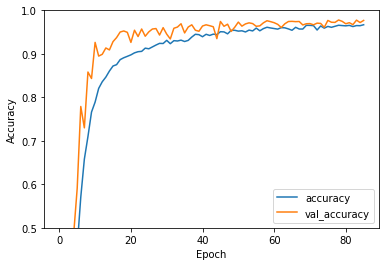

In [50]:
import matplotlib.pyplot as plt

hist = best_model.history

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Best_Model'+'.pickle', 'wb') as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

# with open(data_dir+'Grid_Table_6' +'.pickle', 'wb') as f:
#     pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

In [52]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'

with open(data_dir+'Grid_Table_1' +'.pickle', 'rb') as f:
    result1 = pickle.load(f)
with open(data_dir+'Grid_Table_2' +'.pickle', 'rb') as f:
    result2 = pickle.load(f)
with open(data_dir+'Grid_Table_3' +'.pickle', 'rb') as f:
    result3 = pickle.load(f)
with open(data_dir+'Grid_Table_4' +'.pickle', 'rb') as f:
    result4 = pickle.load(f)
with open(data_dir+'Grid_Table_5' +'.pickle', 'rb') as f:
    result5 = pickle.load(f)

In [55]:
# result1.insert(0,'rodada', 1)
# result2.insert(0,'rodada', 2)
# result3.insert(0,'rodada', 3)
# result4.insert(0,'rodada', 4)
# result5.insert(0,'rodada', 5)
# result.insert(0,'rodada', 6)
resultados = pd.concat([result1,result2,result3,result4, result5, result])
resultados

,rodada,Train_Acc,Val_Acc,Epoch,Time,Param_Trein,Param_N_Trein,n_hidden,conv,n_filter1,kernel_size1,mpool_siz1,n_filter2,kernel_size2,mpool_siz2,n_filter3,kernel_size3,mpool_siz3,n_neurons1,n_neurons2,drop1,drop2,s3,n_filter4,kernel_size4,n_filter5,kernel_size5,n_filter6,kernel_size6,s6,index
0,1,1.0000,0.6565,20.0,6.5,826178.0,0.0,1.0,0.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0000,0.6555,20.0,7.1,1645418.0,0.0,1.0,0.0,16.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.9462,0.5752,20.0,8.4,3283898.0,0.0,1.0,0.0,32.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1.0000,0.6375,20.0,11.1,6560858.0,0.0,1.0,0.0,64.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.9997,0.6797,20.0,7.0,212042.0,0.0,1.0,1.0,8.0,2.0,2.0,8.0,2.0,2.0,0.0,0.0,0.0,256.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,5,0.9554,0.9443,20.0,19.9,1699066.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,5,0.9512,0.9381,20.0,19.4,1699066.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,6,0.9659,0.9585,52.0,266.9,1731834.0,224.0,2.0,2.0,16.0,5.0,5.0,32.0,5.0,2.0,64.0,5.0,5.0,1024.0,1024.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,6,0.9465,0.9564,67.0,346.3,1731834.0,224.0,2.0,2.0,16.0,5.0,5.0,32.0,5.0,2.0,64.0,5.0,5.0,1024.0,1024.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [56]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'Grid_All_Results' +'.pickle', 'wb') as f:
    pickle.dump(resultados, f, pickle.HIGHEST_PROTOCOL)